In [4]:
import scanpy as sc
import muon as mu
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import ctar
import scipy as sp
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from scipy.sparse import csc_matrix

In [5]:
pval_cutoff = 0.05

In [6]:
# Dropping pairs where there are conflicting ground truth classifications depending on cell type
# Dropped 1212 of 75581 pairs
pairs = pd.read_csv("subset_pairs.csv")
pairs_dropna = pd.read_csv("subset_pairs_dropna.csv")
print(pairs.shape, pairs_dropna.shape)

(75581, 9) (74369, 9)


In [9]:
none_indices = pairs.index[pairs['gt_labels'].isna()]
none_indices

Index([    7,    85,   178,   230,   413,   519,   546,   748,   822,   823,
       ...
       75120, 75137, 75144, 75220, 75226, 75279, 75289, 75477, 75481, 75487],
      dtype='int64', length=1212)

# Control Peaks Method

In [5]:
predictions = pd.read_csv("pval_data_cp_labels.csv")
predictions_cleaned = predictions.drop(none_indices)
predictions_cleaned


,Unnamed: 0.1,Unnamed: 0,feature_types,peak,index_z,corr,mc_pval,mc_qval,label
0,0,chr1-181117-181803,ATAC,chr1:181117-181803,0,-0.007827,0.351040,0.963579,False
1,1,chr1-267562-268456,ATAC,chr1:267562-268456,1,0.003687,0.505728,0.993701,False
2,2,chr1-816868-817761,ATAC,chr1:816868-817761,2,0.001387,0.857489,0.999999,False
3,3,chr1-822804-823597,ATAC,chr1:822804-823597,3,-0.001349,0.903973,0.999999,False
4,4,chr1-822804-823597,ATAC,chr1:822804-823597,4,0.005548,0.116021,0.796727,False
...,...,...,...,...,...,...,...,...,...
75576,75576,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,75576,0.003790,0.277203,0.943013,False
75577,75577,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,75577,-0.005030,0.178610,0.876917,False
75578,75578,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,75578,-0.004297,0.418293,0.977477,False
75579,75579,chr9-137878295-137879192,ATAC,chr9:137878295-137879192,75579,0.003055,0.606733,0.999999,False


In [9]:
y_true = pairs_dropna['gt_labels']
y_scores = predictions_cleaned['label']

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

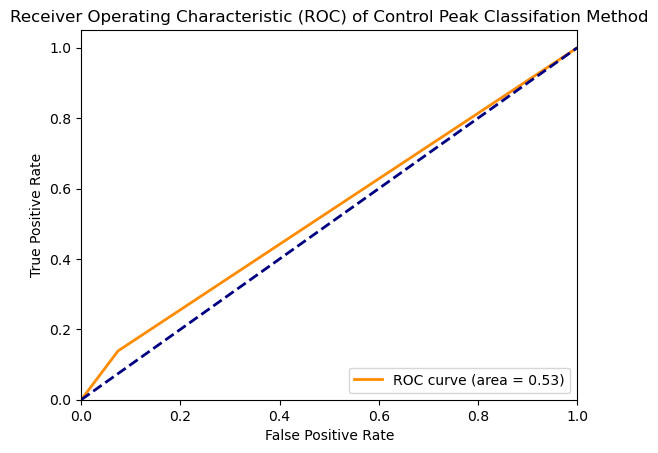

In [11]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of Control Peak Classifation Method')
plt.legend(loc='lower right')
plt.show()

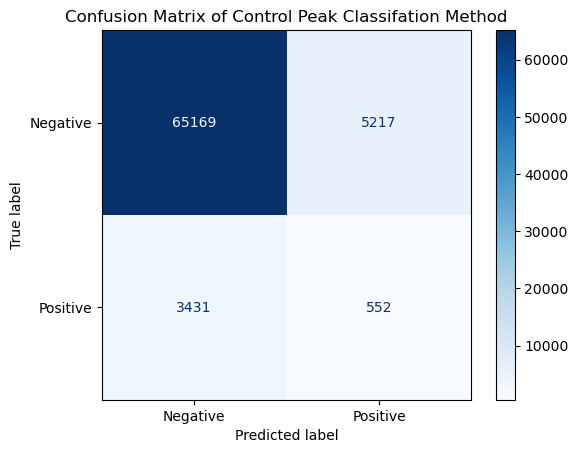

In [17]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_scores, labels=[0, 1])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plot the confusion matrix using matplotlib
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix of Control Peak Classifation Method')
plt.show()

# Permutation Method

In [10]:
predictions = pd.read_csv("pval_data_perm_labels.csv")
predictions_cleaned = predictions.drop(none_indices)
predictions_cleaned


,Unnamed: 0.1,Unnamed: 0,feature_types,peak,corr,mc_pval,mc_qval,label
0,0,chr1-181117-181803,ATAC,chr1:181117-181803,-0.007827,0.046480,0.095525,True
1,1,chr1-267562-268456,ATAC,chr1:267562-268456,0.003687,0.046480,0.095525,True
2,2,chr1-816868-817761,ATAC,chr1:816868-817761,0.001387,1.000000,1.000000,False
3,3,chr1-822804-823597,ATAC,chr1:822804-823597,-0.001349,0.046480,0.095525,True
4,4,chr1-822804-823597,ATAC,chr1:822804-823597,0.005548,0.046480,0.095525,True
...,...,...,...,...,...,...,...,...
75576,75576,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,0.003790,0.046480,0.095525,True
75577,75577,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,-0.005030,1.000000,1.000000,False
75578,75578,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,-0.004297,0.523544,1.000000,False
75579,75579,chr9-137878295-137879192,ATAC,chr9:137878295-137879192,0.003055,1.000000,1.000000,False


In [12]:
y_true = pairs_dropna['gt_labels']
y_scores = predictions_cleaned['label']

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

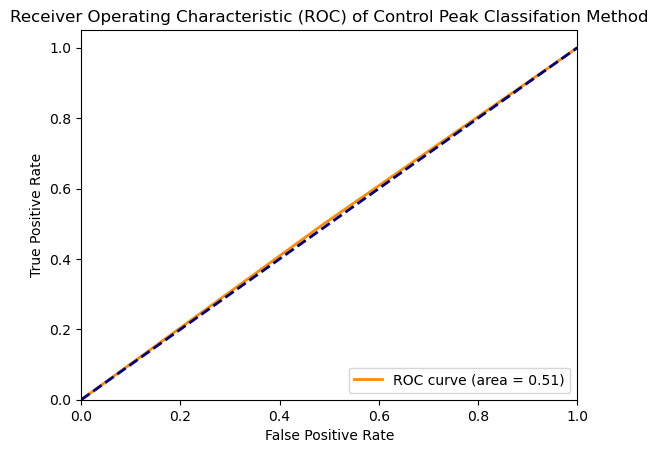

In [13]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of Control Peak Classifation Method')
plt.legend(loc='lower right')
plt.show()

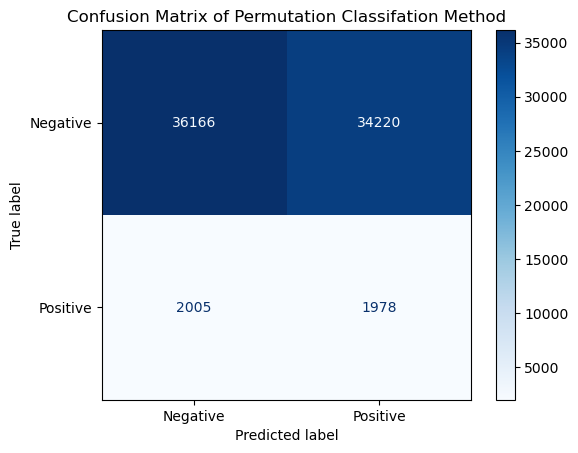

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_scores, labels=[0, 1])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plot the confusion matrix using matplotlib
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix of Permutation Classifation Method')
plt.show()

# Fast CP Method

In [17]:
predictions = pd.read_csv("pval_data_fastcp_labels.csv")
predictions_cleaned = predictions.drop(none_indices)
predictions_cleaned

,Unnamed: 0.1,Unnamed: 0,feature_types,peak,index_z,corr,mc_pval,mc_qval,label
0,0,chr1-181117-181803,ATAC,chr1:181117-181803,0,-0.007827,0.312090,0.954180,False
1,1,chr1-267562-268456,ATAC,chr1:267562-268456,1,0.003687,0.510448,0.994411,False
2,2,chr1-816868-817761,ATAC,chr1:816868-817761,2,0.001387,0.856525,1.000000,False
3,3,chr1-822804-823597,ATAC,chr1:822804-823597,3,-0.001349,0.923963,1.000000,False
4,4,chr1-822804-823597,ATAC,chr1:822804-823597,4,0.005548,0.102741,0.774521,False
...,...,...,...,...,...,...,...,...,...
75576,75576,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,75576,0.003790,0.324686,0.956119,False
75577,75577,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,75577,-0.005030,0.172306,0.868351,False
75578,75578,chr9-137836356-137837280,ATAC,chr9:137836356-137837280,75578,-0.004297,0.376039,0.970623,False
75579,75579,chr9-137878295-137879192,ATAC,chr9:137878295-137879192,75579,0.003055,0.556523,1.000000,False


In [18]:
y_true = pairs_dropna['gt_labels']
y_scores = predictions_cleaned['label']

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

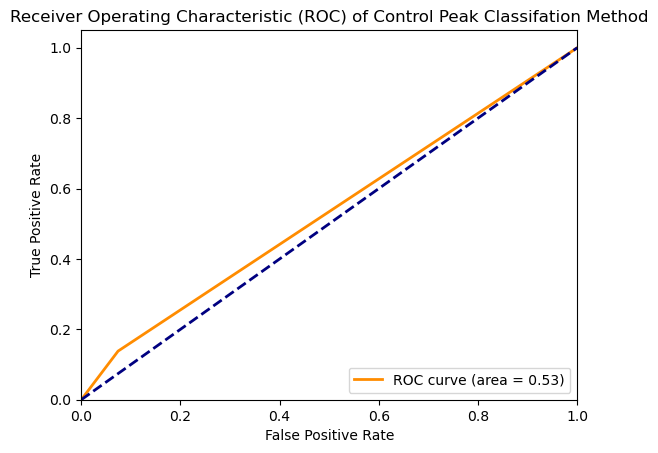

In [19]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of Control Peak Classifation Method')
plt.legend(loc='lower right')
plt.show()

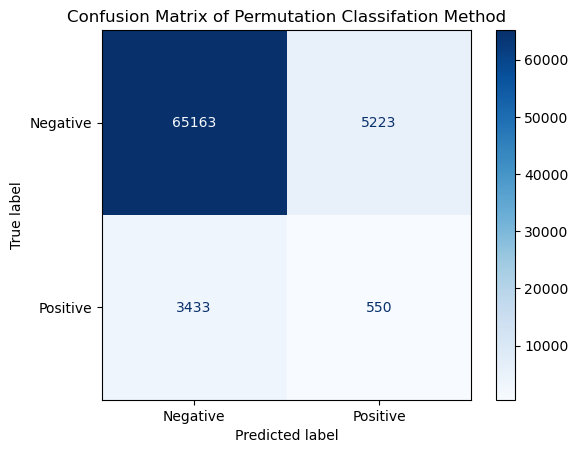

In [21]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_scores, labels=[0, 1])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plot the confusion matrix using matplotlib
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix of Permutation Classifation Method')
plt.show()